In [107]:
source('../NMEG_utils/r_functions/load_nmeg.r')
library('xts')
library('forecast')
library('tseries')
library('astsa')

In [108]:
site <- 'Mpj'
flux <- daily_to_xts(get_daily_file(site, 'aflx', make_new=FALSE))
soil <- daily_to_xts(get_daily_file(site, 'soilmet', make_new=FALSE))

In [109]:
get_decomp <- function(dframe, freq='Daily', sitename='Site ts decomp', per=52, plotdecomp=TRUE){
    ts1 <- dframe
    if (freq=='Daily'){
        attr(ts1, 'frequency') <- 365
    } else if (freq=='Weekly'){
        attr(ts1, 'frequency') <- 52
    } else if (freq=='Monthly'){
        attr(ts1, 'frequency') <- 12
    }
    # Timeseries decomp
    decomp_ts1 <- stl(as.ts(ts1), s.window="per", na.action=na.omit, robust=TRUE)
    if (plotdecomp==TRUE){ plot(decomp_ts1, main=site)}
    # Not sure why making a zoo first is needed
    decomp <- as.xts(zoo(decomp_ts1$time.series, index(dframe)))
    return(decomp)
}

In [110]:
p <- apply.weekly(flux$P_F, sum)
swc <- apply.weekly(soil$deep_swc_interp, mean)
nee <- apply.weekly(flux$FC_F_g_int, mean)
gpp <- apply.weekly(flux$GPP_g_int, mean)
re <- apply.weekly(flux$RECO_g_int, mean)

#Check for missing data and crop timeseries
sum(is.na(p))
p <- p[54:nrow(p)]
sum(is.na(swc))
swc <- swc[125:nrow(swc)]
# Could use other carbon fluxes here
sum(is.na(nee))
nee <- nee[54:nrow(nee)]

# Test for stationarity
# Augemented Dickey-Fuller Test
# A significant p-value means that no unit root is present (no need for differencing)
# Rejecting the null hypothesis suggests that a time series as stationary (from the tseries package)
adf.test(p)
adf.test(swc)
adf.test(nee)

[1] 53

[1] 124

[1] 53

Warning message:
In adf.test(p): p-value smaller than printed p-value


	Augmented Dickey-Fuller Test

data:  p
Dickey-Fuller = -5.1925, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  swc
Dickey-Fuller = -3.6126, Lag order = 6, p-value = 0.03228
alternative hypothesis: stationary


Warning message:
In adf.test(nee): p-value smaller than printed p-value


	Augmented Dickey-Fuller Test

data:  nee
Dickey-Fuller = -6.0533, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


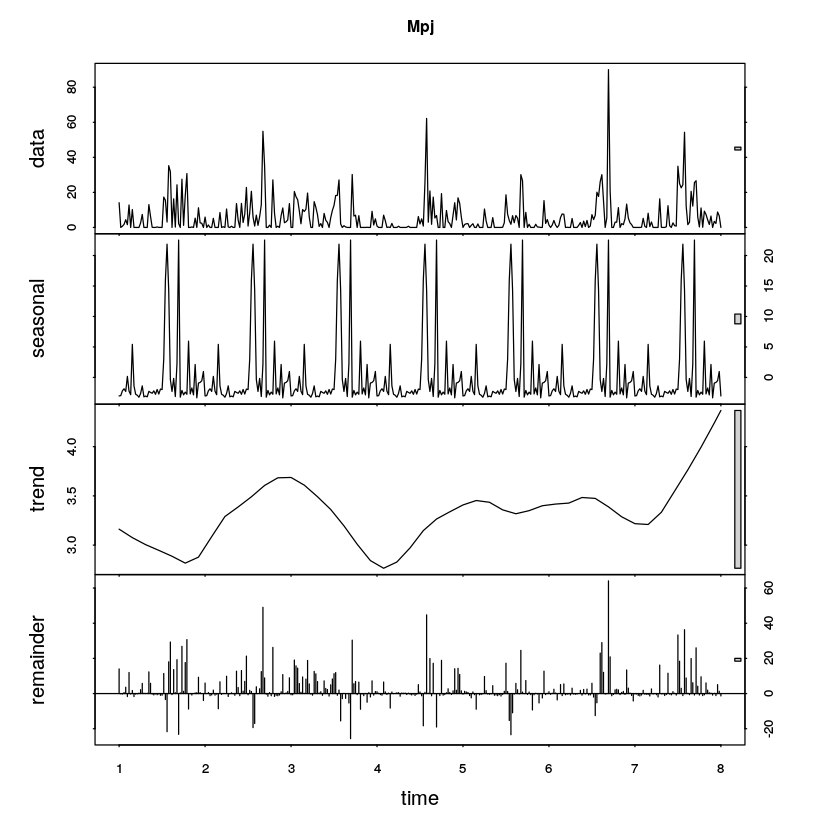

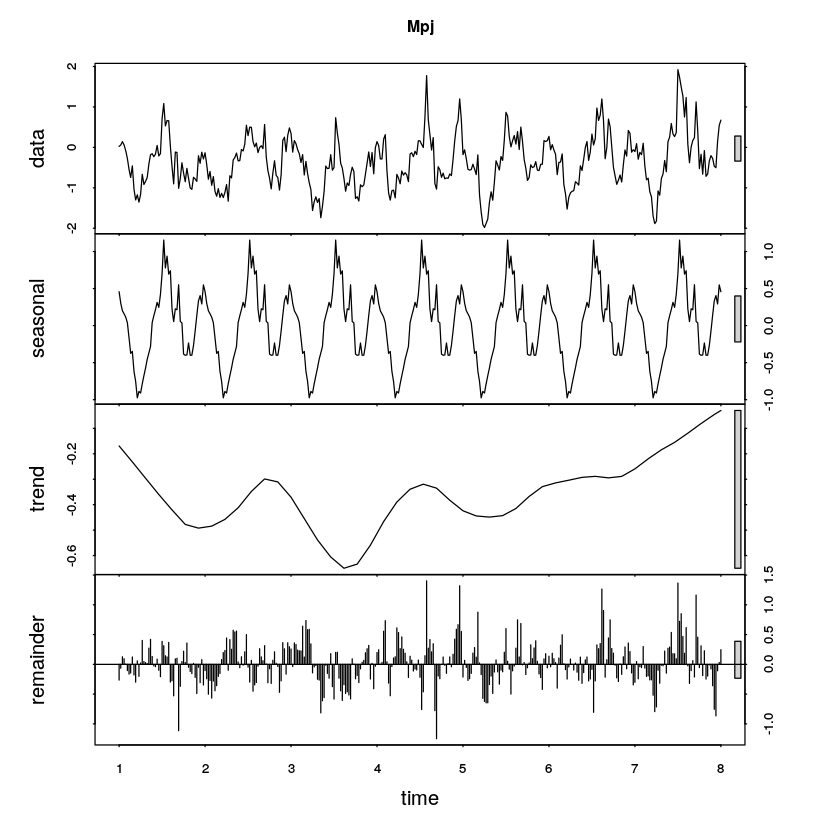

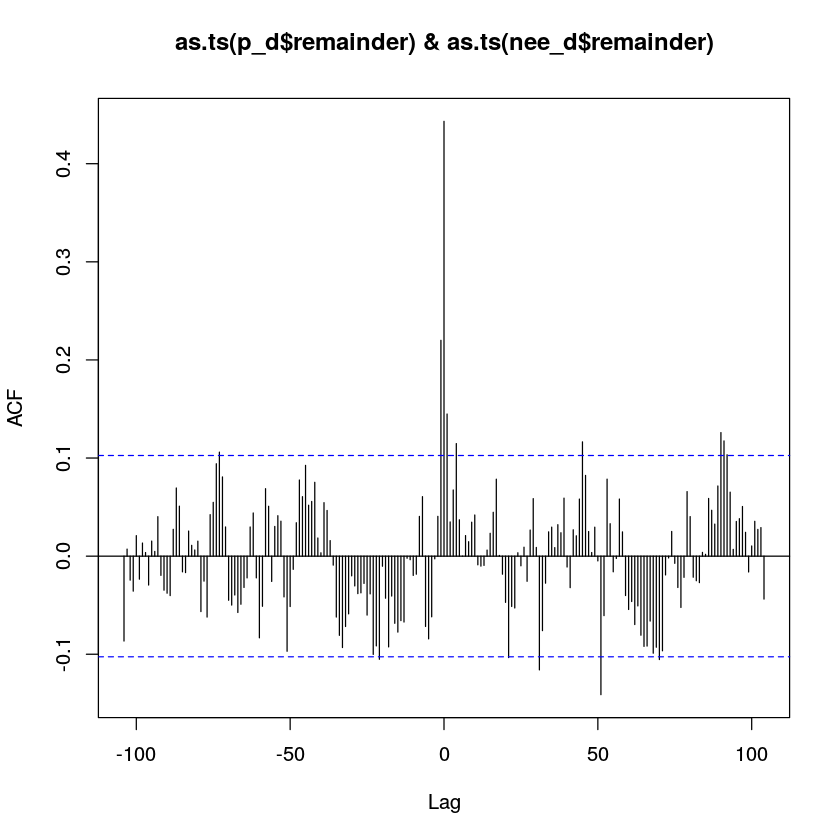

In [111]:
# Decompose and perform cross correlation
p_d <- get_decomp(p, freq='Weekly', sitename=site)
nee_d <- get_decomp(nee, freq='Weekly', sitename=site)
ccf(as.ts(p_d$remainder), as.ts(nee_d$remainder), lag.max=104, na.action=na.omit)

## Precip model


Call:
arima(x = p, order = c(1, 0, 0), xreg = time(p))

Coefficients:
         ar1  intercept  time(p)
      0.3066     0.6712    3e-04
s.e.  0.0498    14.7876    1e-03

sigma^2 estimated as 91.19:  log likelihood = -1341.58,  aic = 2691.16

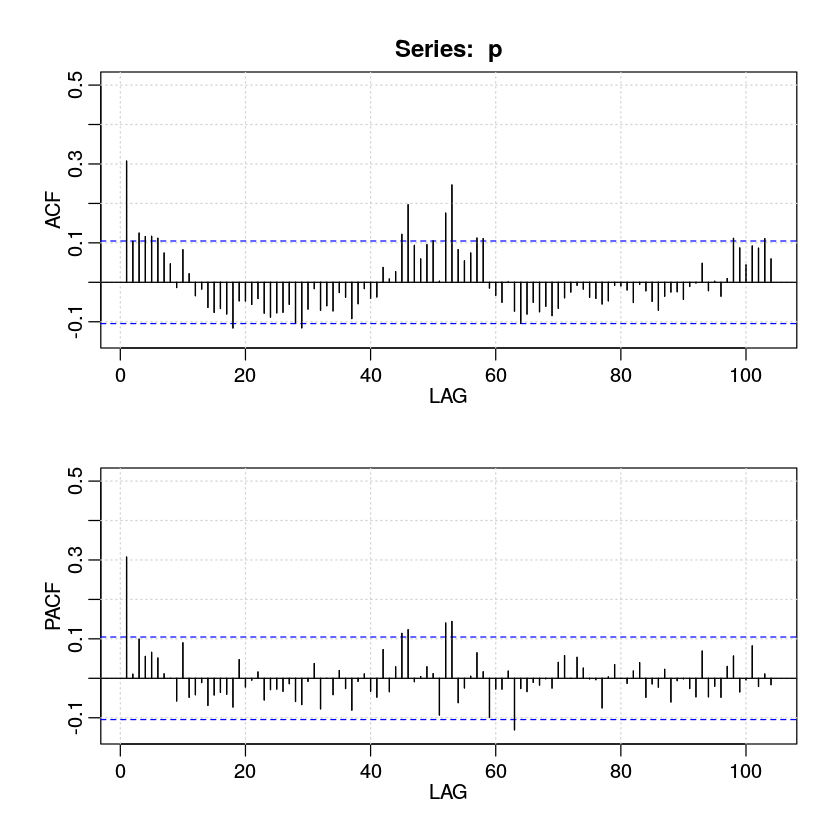

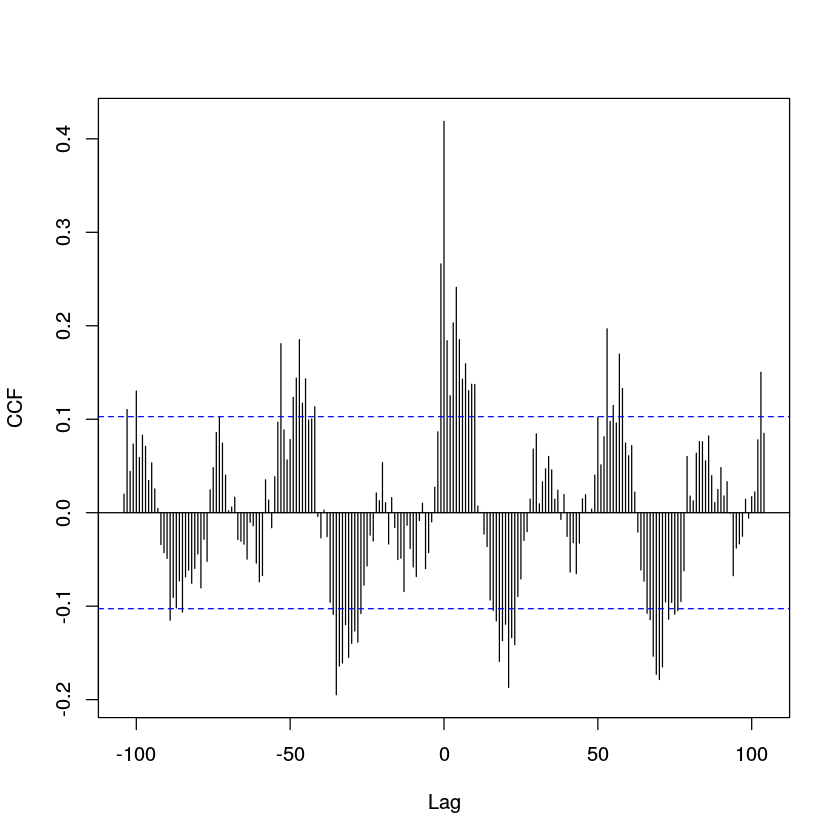

In [112]:
# Could use other carbon fluxes here
fc <- nee
silent <- acf2(p, max.lag=104)
(fit = arima(p, xreg=time(p), order=c(1, 0, 0)))
ar1 = as.numeric(fit$coef[1]) # = 0.8272
p.pw = resid(fit)
fc.d = resid(lm(fc~time(fc), na.action=NULL))
fc.fil = filter(fc.d, filter=c(1, -ar1), method="conv", sides=1)
ccf(p.pw, fc.fil, lag.max=104, main="", ylab="CCF", na.action=na.omit)


Call:
lm(formula = fc.d ~ 0 + fc.d1 + p.d1 + p.d40, data = fc_vars)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02978 -0.22517 -0.02227  0.21089  1.64910 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
fc.d1  8.343e-01  3.471e-02  24.037   <2e-16 ***
p.d1  -7.019e-04  1.943e-03  -0.361    0.718    
p.d40  2.365e-05  1.859e-03   0.013    0.990    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3602 on 322 degrees of freedom
Multiple R-squared:  0.684,	Adjusted R-squared:  0.681 
F-statistic: 232.3 on 3 and 322 DF,  p-value: < 2.2e-16



Call:
arima(x = eta.hat, order = c(3, 0, 0))

Coefficients:
         ar1      ar2     ar3  intercept
      1.0135  -0.8622  0.0761     0.0030
s.e.  0.0554   0.0625  0.0553     0.0256

sigma^2 estimated as 0.1267:  log likelihood = -126.56,  aic = 263.12

 Time-Series [1:365] from 1 to 365: 0.569 0.603 0.685 0.602 0.459 ...


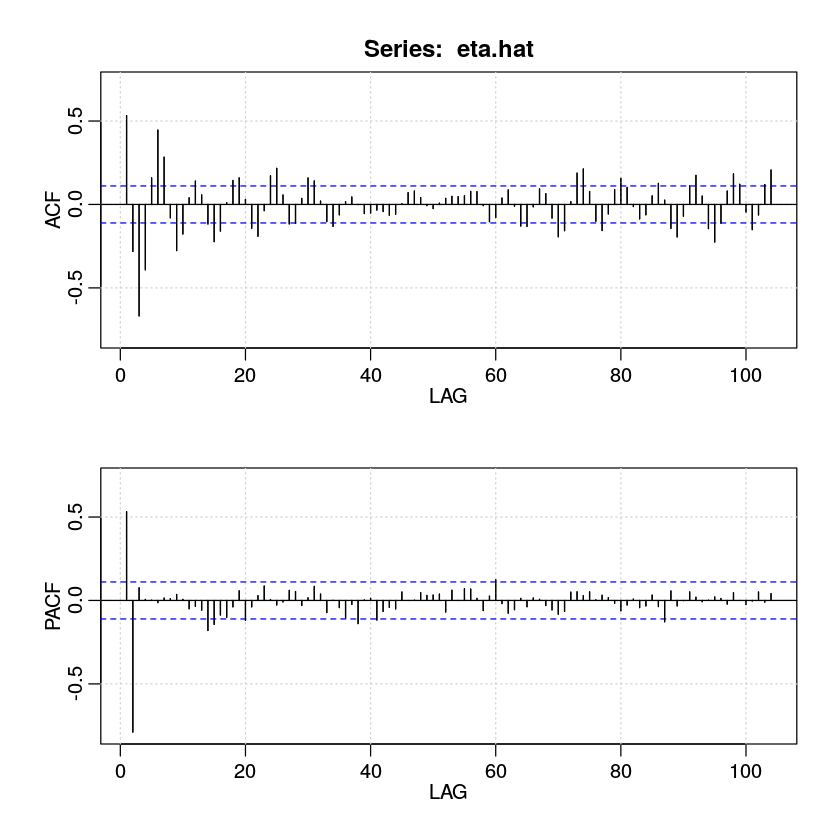

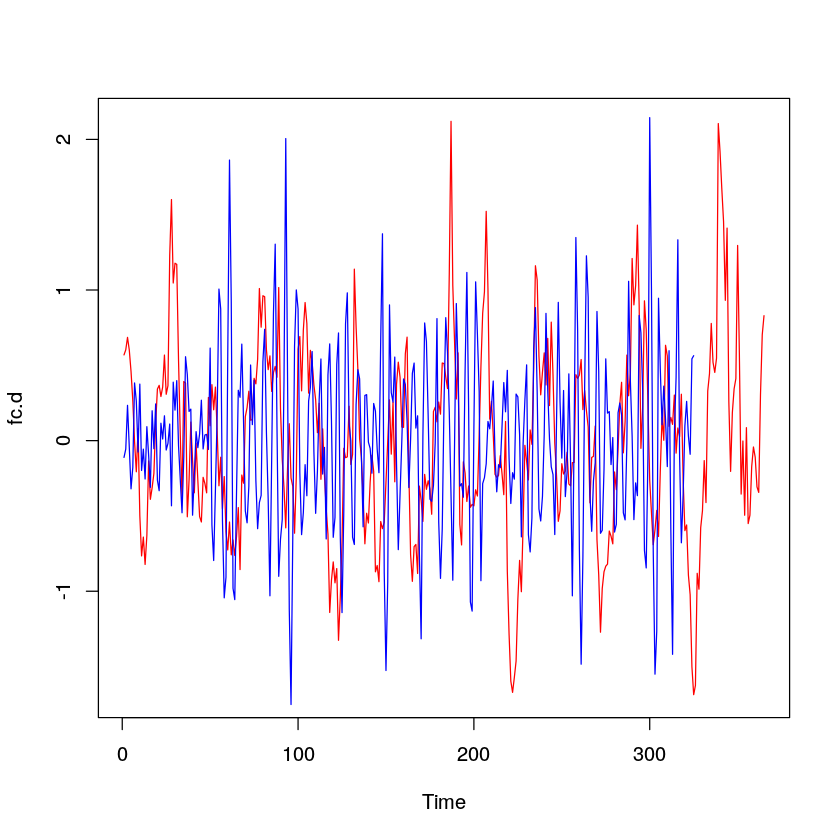

In [115]:
fc.d = resid(lm(fc~time(fc), na.action=NULL))
p.d = resid(lm(p~time(p), na.action=NULL))
fc.d <- as.ts(fc.d)
# Use p or p.d in lags?
fc_vars <- ts.intersect(fc.d, fc.d1=lag(fc.d,-1), p.d1=lag(p_ts,-1), p.d40=lag(p_ts,-40), dframe=TRUE)
summary(fc.fit <- lm(fc.d~0+fc.d1+p.d1+p.d40, data=fc_vars))

om1 = as.numeric(fc.fit$coef[1])
eta.hat = filter(resid(fc.fit), filter=c(1,-om1), method="recur", sides=1)
silent <- acf2(eta.hat, max.lag=104)
(eta.fit <- arima(eta.hat, order=c(3,0,0)))
str(fc.d)
plot(fc.d,col="red")
lines(fitted(eta.fit),col="blue")

## SWC model

[1] 0

Warning message:
In sqrt(diag(x$var.coef)): NaNs producedWarning message:
In sqrt(diag(x$var.coef)): NaNs produced


Call:
arima(x = s, order = c(2, 0, 0), xreg = time(s))

Coefficients:
        ar1      ar2  intercept  time(s)
      1.495  -0.5427     0.1080        0
s.e.    NaN      NaN     0.2024      NaN

sigma^2 estimated as 5.652e-05:  log likelihood = 1018.87,  aic = -2027.75

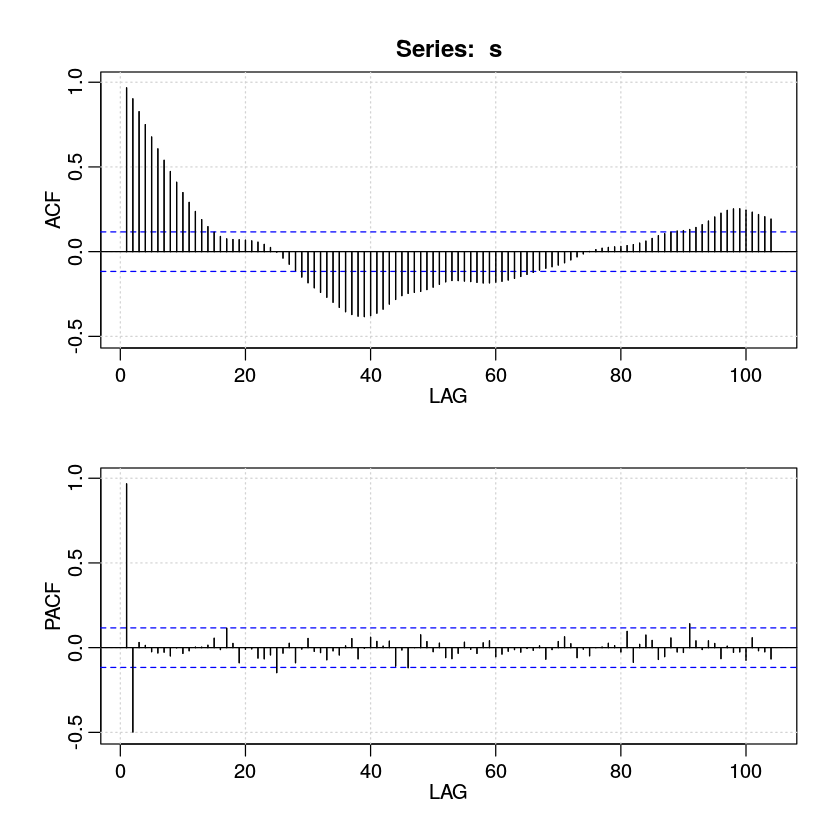

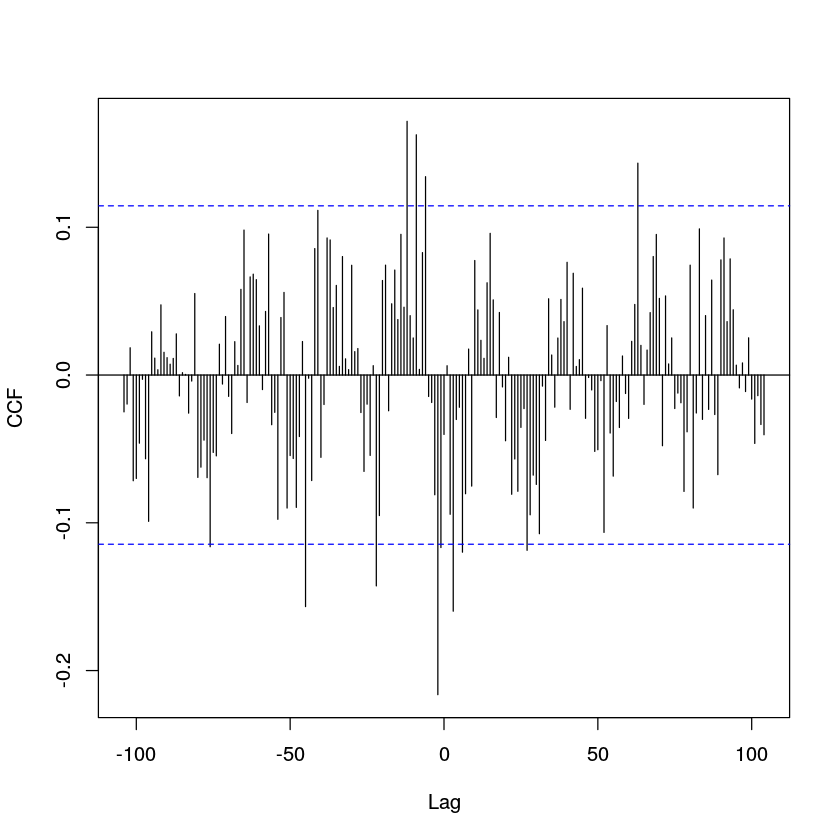

In [120]:
fc <- nee
s <- swc
# These are different lengths - make sure they match
x <- nrow(nee) - nrow(swc)
fc <- nee[(x+1):nrow(nee)]
nrow(fc) - nrow(swc)

silent <- acf2(s, max.lag=104)
(fit = arima(s, xreg=time(s), order=c(2, 0, 0)))
ar1 = as.numeric(fit$coef[1]) # = 0.8272
s.pw = resid(fit)
fc.d = resid(lm(fc~time(fc), na.action=NULL))
fc.fil = filter(fc.d, filter=c(1, -ar1), method="conv", sides=1)
ccf(s.pw, fc.fil, lag.max=104, main="", ylab="CCF", na.action=na.omit)


Call:
lm(formula = fc.d ~ 0 + fc.d1 + s.d3, data = nee)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02266 -0.21848 -0.01647  0.22363  1.66193 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
fc.d1  0.82175    0.03671  22.386   <2e-16 ***
s.d3  -0.10166    0.20963  -0.485    0.628    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3798 on 242 degrees of freedom
Multiple R-squared:  0.6816,	Adjusted R-squared:  0.679 
F-statistic:   259 on 2 and 242 DF,  p-value: < 2.2e-16


ACF,PACF
0.54,0.54
-0.25,-0.76
-0.61,0.11
-0.37,-0.02
0.11,-0.04
0.34,-0.01
0.22,-0.01
-0.04,0.05
-0.15,0.04
-0.08,0.02



Call:
arima(x = eta.hat, order = c(3, 0, 0))

Coefficients:
         ar1      ar2     ar3  intercept
      1.0368  -0.8698  0.1110     0.0163
s.e.  0.0637   0.0729  0.0637     0.0331

sigma^2 estimated as 0.1391:  log likelihood = -106.67,  aic = 223.33

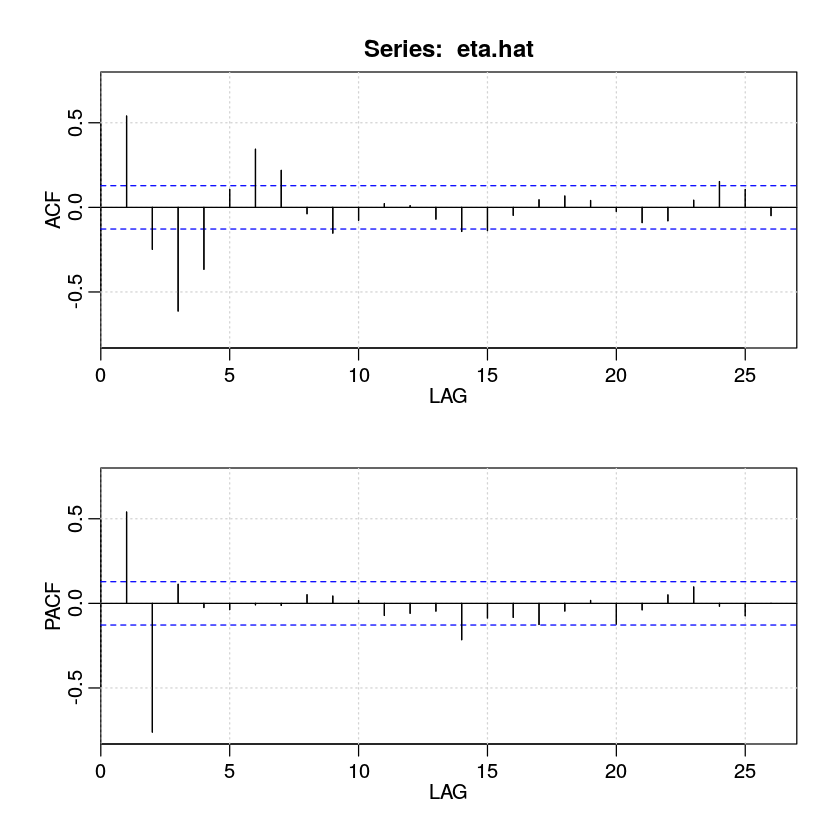

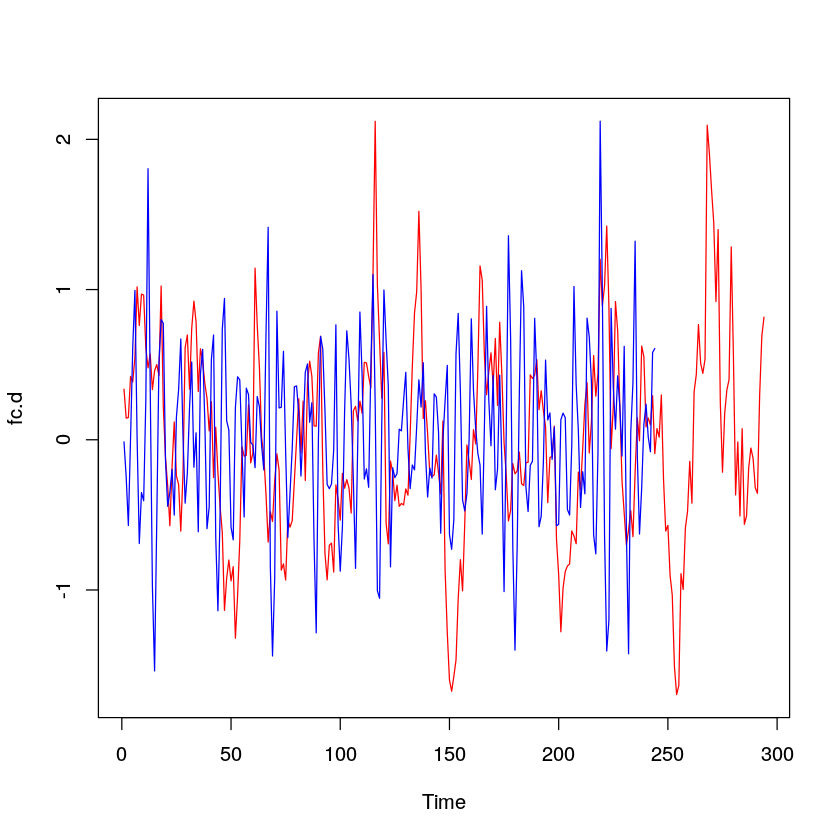

In [129]:
# Detrend fc and swc - should we also remove seasonal components?
fc.d = resid(lm(fc~time(fc), na.action=NULL))
s.d = resid(lm(s~time(s), na.action=NULL))
fc.d <- as.ts(fc.d)
s <- as.ts(s)
# Make multivariate timeseries with detrended fc, lagged fc, and lagged swc
nee = ts.intersect(fc.d, fc.d1=lag(fc.d,-1), s.d3=lag(s,-3), s.d50=lag(s,-50),dframe=TRUE)
# Make linear model
summary(nee.fit <- lm(fc.d~0+fc.d1+s.d3, data=nee))
# Get coefficient

om1 = as.numeric(nee.fit$coef[1])
eta.hat = filter(resid(nee.fit), filter=c(1,-om1), method="recur", sides=1)
acf2(eta.hat)
(eta.fit <- arima(eta.hat, order=c(3,0,0)))

plot(fc.d,col="red")
#lines(fitted(lm(fc~time(fc), na.action=NULL)), col='black')
lines(fitted(eta.fit),col="blue")